# DENSENET 121 Moldel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers      import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models      import Model
from tensorflow.keras.optimizers  import Adam
from tensorflow.keras.models import load_model, Model
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Model as KModel

from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             roc_curve, auc)

# Plotting
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import imageio






In [ ]:
!nvidia-smi

Mon Apr 28 02:31:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

##Upload data

In [ ]:
!unzip -q "/content/drive/MyDrive/Deep_Learning_Proyect/real_vs_fake2.zip" -d /content/real_vs_fake

In [ ]:
base_dir = "/content/real_vs_fake/real_vs_fake"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
valid_dir = os.path.join(base_dir, "valid")

print("Train:", os.listdir(train_dir))
print("Valid:", os.listdir(valid_dir))
print("Test:", os.listdir(test_dir))

Train: ['real', 'fake']
Valid: ['real', 'fake']
Test: ['real', 'fake']


## Preprocessing DATA

In [ ]:
Target_Size_DSN = (256, 256)
BATCH_SIZE = 64
NUM_EPOCHS = 3
#Normalize pixel values to between 0 and 1
data_gen = ImageDataGenerator(rescale=1./255)

train_ds_DSN = data_gen.flow_from_directory(
    train_dir,
    target_size=Target_Size_DSN,
    batch_size=BATCH_SIZE,
    class_mode='binary')

valid_ds_DSN = data_gen.flow_from_directory(
    valid_dir,
    target_size=Target_Size_DSN,
    batch_size=BATCH_SIZE,
    class_mode='binary')

test_ds_DSN = data_gen.flow_from_directory(
    test_dir,
    target_size=Target_Size_DSN,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
checkpoint_filepath = "/content/drive/MyDrive/Deep_Learning_Proyect/model_DSN.weights.h5"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True)

In [ ]:
#stops training when val_loss does not improve furter
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#reduce learning rate when it doesn't improve
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=3)

## DenseNet Architecture

In [ ]:
input_shape_DSN = (256, 256, 3)
def get_model_DSN(hp):
    # Load the DenseNet121 model with pre-trained weights
    # and without the top layer (include_top=False)
    # Set the input shape to match the dataset
    input = tf.keras.Input(shape=input_shape_DSN)
    #Load model without classifier/fully connected layers
    base_model_DSN = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_tensor=input, input_shape=input_shape_DSN)#, input_shape=input_shape, pooling='avg')
    #add custom layers
    x = base_model_DSN.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(448, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x) # Binary Class

    model_DSN=tf.keras.Model(inputs=base_model_DSN.input, outputs=predictions)
    #optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4]))
    model_DSN.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model_DSN

In [ ]:
best_model_DSN = get_model_DSN(input_shape_DSN)

#best_model_DSN2.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Training the DSN model

In [ ]:
history_DSN = best_model_DSN.fit(train_ds_DSN,
                       epochs = 10,
                       validation_data = valid_ds_DSN,
                       callbacks=[checkpoint_cb, early_stopping, reduce_lr],verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 507s 222ms/step - accuracy: 0.9171 - loss: 0.1947 - val_accuracy: 0.8174 - val_loss: 0.5615 - learning_rate: 0.0010
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 239s 153ms/step - accuracy: 0.9833 - loss: 0.0454 - val_accuracy: 0.9250 - val_loss: 0.2013 - learning_rate: 0.0010
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 238s 152ms/step - accuracy: 0.9887 - loss: 0.0308 - val_accuracy: 0.6425 - val_loss: 1.7357 - learning_rate: 0.0010
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 240s 154ms/step - accuracy: 0.9905 - loss: 0.0272 - val_accuracy: 0.9452 - val_loss: 0.1390 - learning_rate: 0.0010
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 235s 150ms/step - accuracy: 0.9927 - loss: 0.0205 - val_accuracy: 0.9624 - val_loss: 0.1537 - learning_rate: 0.0010
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 241s 154ms/step - accuracy: 0.9933 - loss: 0.0181 - val_accuracy: 0.9579 - val_loss: 0.1218 - learning_rate: 0.0010
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 239s 153ms/step - acc

## Best Model Results

In [ ]:
# Save the entire model to H5 format
best_model_DSN.save('/content/drive/MyDrive/Deep_Learning_Proyect/final_DSN_model.h5')

# Save the entire model to the new Keras format (.keras)
best_model_DSN.save('/content/drive/MyDrive/Deep_Learning_Proyect/final_DSN_model.keras')

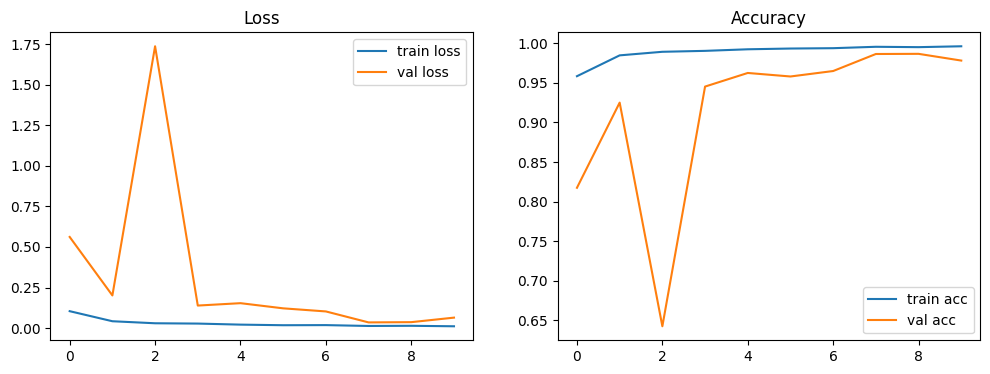

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_DSN.history['loss'], label='train loss')
plt.plot(history_DSN.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_DSN.history['accuracy'], label='train acc')
plt.plot(history_DSN.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Final evaluation & metrics on validation and test
# validation
print("\n--- VALIDATION DSN EVALUATION ---")
val_loss, val_acc = best_model_DSN.evaluate(valid_ds_DSN, verbose=1)
print(f"Val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")

# test
print("\n--- TEST DSN EVALUATION ---")
test_loss, test_acc = best_model_DSN.evaluate(test_ds_DSN, verbose=1)
print(f"Test loss: {test_loss:.4f}, test acc: {test_acc:.4f}")


--- VALIDATION DSN EVALUATION ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - accuracy: 0.9863 - loss: 0.0367
Val loss: 0.0352, val acc: 0.9863

--- TEST DSN EVALUATION ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 125ms/step - accuracy: 0.9933 - loss: 0.0190
Test loss: 0.0356, test acc: 0.9873


In [ ]:
# preds on test
y_true = test_ds_DSN.classes
y_prob = best_model_DSN.predict(test_ds_DSN).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# confusion matrix + classification report
print("\nConfusion Matrix (test):")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report (test):")
print(classification_report(y_true, y_pred, digits=4))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(64, 256, 256, 3))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 159ms/step

Confusion Matrix (test):
[[9974   26]
 [ 228 9772]]

Classification Report (test):
              precision    recall  f1-score   support

           0     0.9777    0.9974    0.9874     10000
           1     0.9973    0.9772    0.9872     10000

    accuracy                         0.9873     20000
   macro avg     0.9875    0.9873    0.9873     20000
weighted avg     0.9875    0.9873    0.9873     20000



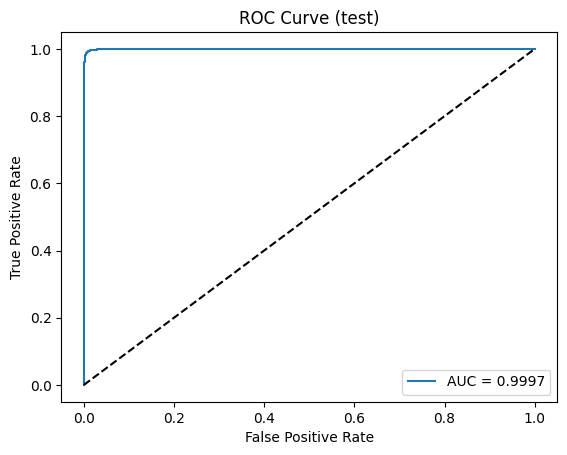

In [ ]:
# ROC curve + AUC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (test)')
plt.legend(loc='lower right')
plt.show()

## Qualitative Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


Text(0.5, 1.0, 'This image is 0.001% Fake and 99.999% Real.')

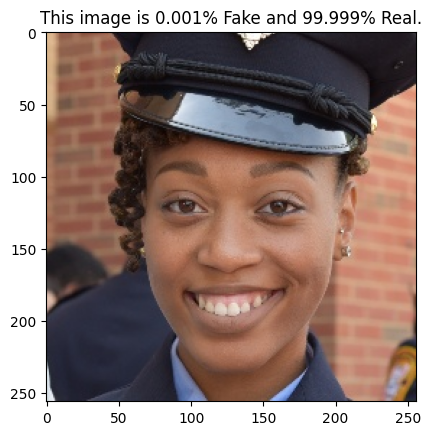

In [ ]:
model_path = '/content/drive/MyDrive/Deep_Learning_Proyect/final_DSN_model.keras'
model_bestDSN = load_model(model_path)
#real example
test_image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Deep_Learning_Proyect/Images_Example/real/01088.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model_bestDSN.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.3f}% Fake and {100 * result[0][0]:.3f}% Real.")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 368 variables whereas the saved optimizer has 734 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


Text(0.5, 1.0, 'This image is 0.001% Fake and 99.999% Real.')

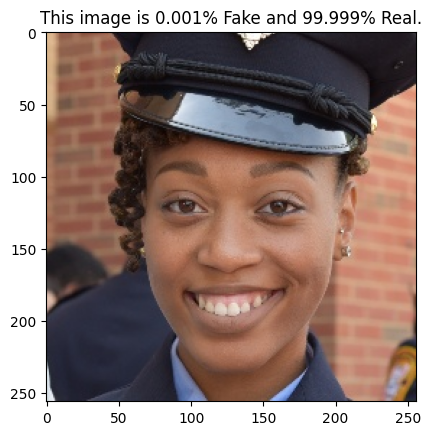

In [ ]:
model_path_DSN = '/content/drive/MyDrive/Deep_Learning_Proyect/final_DSN_model.keras'
model_bestDSN = load_model(model_path_DSN)

#First example
image_qlt = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Deep_Learning_Proyect/Images_Example/real/01088.jpg', target_size=(256, 256, 3))
plt.imshow(image_qlt)


image_qlt_perc = tf.keras.preprocessing.image.img_to_array(image_qlt)
image_qlt_perc = np.expand_dims(image_qlt, axis=0)
image_qlt_perc = image_qlt_perc/255.


result = model_bestDSN.predict(image_qlt_perc)

plt.title(f"This image is {100 * (1 - result[0][0]):.3f}% Fake and {100 * result[0][0]:.3f}% Real.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Text(0.5, 1.0, 'This image is 0.000% Fake and 100.000% Real.')

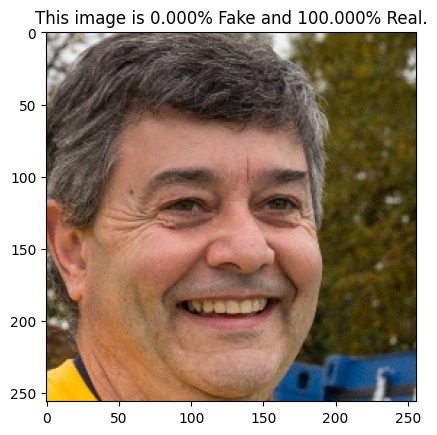

In [ ]:
#Second example
image_qlt2 = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Deep_Learning_Proyect/Images_Example/real/01353.jpg', target_size=(256, 256, 3))
plt.imshow(image_qlt2)


image_qlt_perc2 = tf.keras.preprocessing.image.img_to_array(image_qlt2)
image_qlt_perc2 = np.expand_dims(image_qlt2, axis=0)
image_qlt_perc2 = image_qlt_perc2/255.


result2 = model_bestDSN.predict(image_qlt_perc2)

plt.title(f"This image is {100 * (1 - result2[0][0]):.3f}% Fake and {100 * result2[0][0]:.3f}% Real.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Text(0.5, 1.0, 'This image is 100.000% Fake and 0.000% Real.')

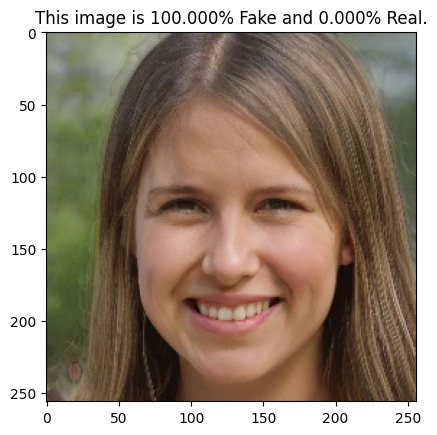

In [ ]:
# Third Example
image_qlt3 = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Deep_Learning_Proyect/Images_Example/fake/0TMADFV2AF.jpg', target_size=(256, 256, 3))
plt.imshow(image_qlt3)


image_qlt_perc3 = tf.keras.preprocessing.image.img_to_array(image_qlt3)
image_qlt_perc3 = np.expand_dims(image_qlt3, axis=0)
image_qlt_perc3 = image_qlt_perc3/255.


result3 = model_bestDSN.predict(image_qlt_perc3)

plt.title(f"This image is {100 * (1 - result3[0][0]):.3f}% Fake and {100 * result3[0][0]:.3f}% Real.")

##Grad-Cam

Gradient-weighted Class Activation Mapping (Grad-CAM) helps us visualize how a DenseNet makes its classification decisions. It does this by using the gradients of the classification score with respect to the network’s convolutional feature maps to identify which regions of the image contribute most to the decision.

In [ ]:
model_path_DSN = '/content/drive/MyDrive/Deep_Learning_Proyect/final_DSN_model.keras'
model_bestDSN = load_model(model_path_DSN)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 368 variables whereas the saved optimizer has 734 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def preprocess_image(image_path, target_dims):
    # Load and resize the image
    raw_img = keras.utils.load_img(image_path, target_size=target_dims)
    img_array = keras.utils.img_to_array(raw_img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

In [ ]:
def generate_cam_heatmap(input_tensor, trained_model, conv_layer_name, target_class_idx=None):
    # Create a model to map input to activations and predictions
    activation_model = keras.models.Model(
        trained_model.inputs,
        [trained_model.get_layer(conv_layer_name).output, trained_model.output]
    )

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_output, predictions = activation_model(input_tensor)
        if target_class_idx is None:
            target_class_idx = tf.argmax(predictions[0])
        focus_class = predictions[:, target_class_idx]

    # Get gradients of the target class with respect to conv layer
    gradients = tape.gradient(focus_class, conv_output)
    channel_importance = tf.reduce_mean(gradients, axis=(0, 1, 2))

    # Weight the conv output by importance
    conv_output = conv_output[0]
    cam_map = conv_output @ channel_importance[..., tf.newaxis]
    cam_map = tf.squeeze(cam_map)

    # Normalize for visualization
    cam_map = tf.maximum(cam_map, 0) / tf.math.reduce_max(cam_map)
    return cam_map.numpy()

In [ ]:
def overlay_cam_on_image(original_img_path, cam_array, output_img_path="gradcam_output.jpg", opacity=0.5):
    original_img = keras.utils.load_img(original_img_path)
    original_arr = keras.utils.img_to_array(original_img)

    # Scale CAM heatmap to 0-255
    cam_scaled = np.uint8(255 * cam_array)

    # Apply color mapping
    colormap = cm.get_cmap("jet")
    colored_map = colormap(np.arange(256))[:, :3]
    cam_color = colored_map[cam_scaled]

    # Convert to image and resize
    cam_img = keras.utils.array_to_img(cam_color)
    cam_img = cam_img.resize((original_arr.shape[1], original_arr.shape[0]))
    cam_img = keras.utils.img_to_array(cam_img)

    # Blend the heatmap with the image
    blended = cam_img * opacity + original_arr
    blended_img = keras.utils.array_to_img(blended)

    # Save and show
    blended_img.save(output_img_path)
    display(Image(output_img_path))

In [ ]:
# Print all layer names in the model
for i in range(len(model_bestDSN.layers)):
    print(model_bestDSN.get_layer(index=i).name)

input_layer
zero_padding2d
conv1_conv
conv1_bn
conv1_relu
zero_padding2d_1
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
con

In [ ]:
# Set image parameters
input_shape = (256, 256)
final_conv_layer = "conv5_block16_1_conv"
image_file = '/content/drive/MyDrive/Deep_Learning_Proyect/Images_Example/fake/0TMADFV2AF.jpg'

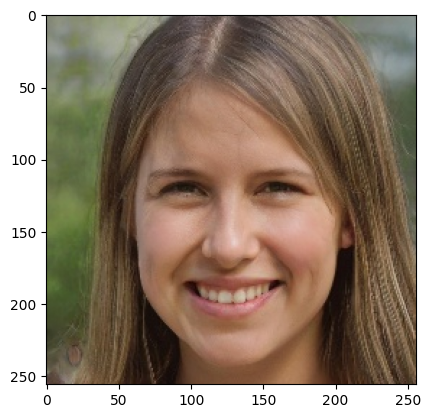

In [ ]:
# Preprocess and visualize test image
loaded_image = tf.keras.preprocessing.image.load_img(image_file, target_size=(256, 256, 3))
plt.imshow(loaded_image)

processed_array = tf.keras.preprocessing.image.img_to_array(loaded_image)
processed_array = np.expand_dims(processed_array, axis=0)
processed_array = processed_array / 255.

In [ ]:
# Disable softmax for CAM
model_bestDSN.layers[-1].activation = None

# Predict and show output
predictions = model_bestDSN.predict(processed_array)
print("Model output:", predictions)

# Generate CAMs from several layers
cam1 = generate_cam_heatmap(processed_array, model_bestDSN, "conv5_block16_1_conv")
cam2 = generate_cam_heatmap(processed_array, model_bestDSN, "conv5_block16_2_conv")
cam3 = generate_cam_heatmap(processed_array, model_bestDSN, "conv5_block15_1_conv")
cam4 = generate_cam_heatmap(processed_array, model_bestDSN, "conv5_block14_1_conv")
cam5 = generate_cam_heatmap(processed_array, model_bestDSN, "conv5_block13_2_conv")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Model output: [[-26.08081]]


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


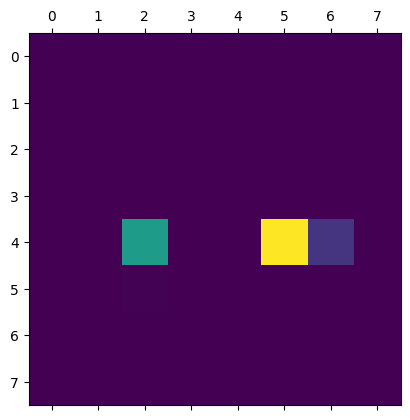

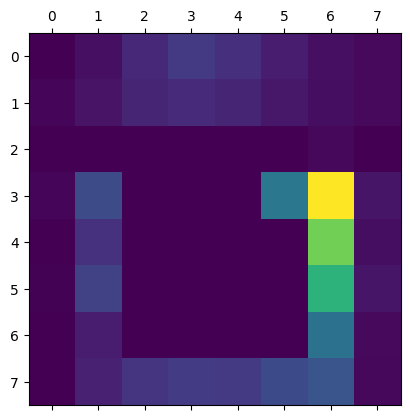

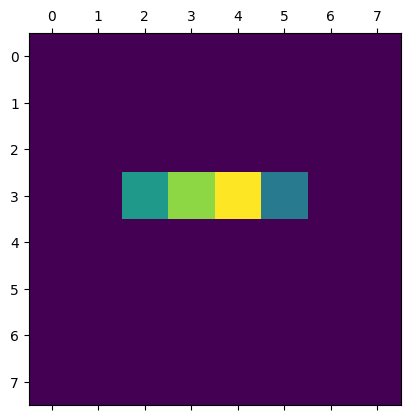

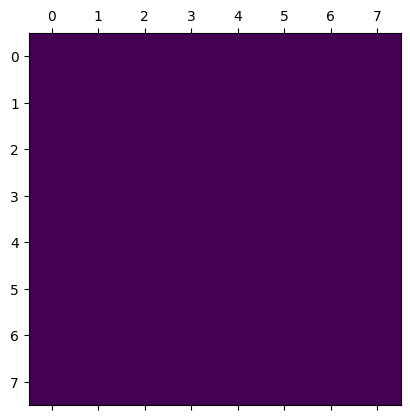

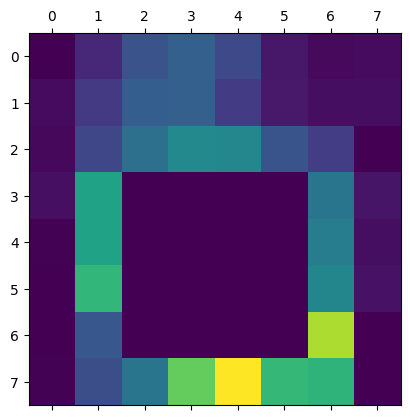

In [ ]:
# Show CAMs
plt.matshow(cam1)
plt.matshow(cam2)
plt.matshow(cam3)
plt.matshow(cam4)
plt.matshow(cam5)
plt.show()

<ipython-input-9-8e1a922e9718>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("jet")


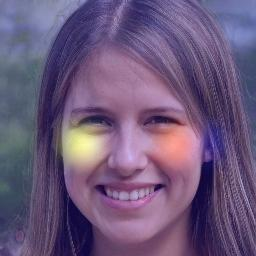

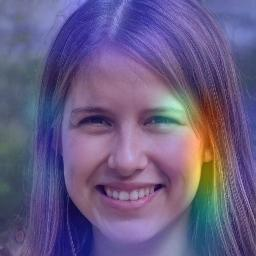

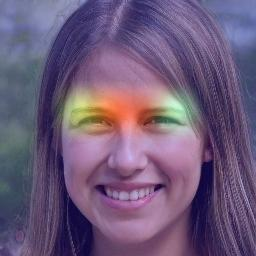

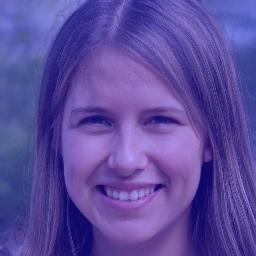

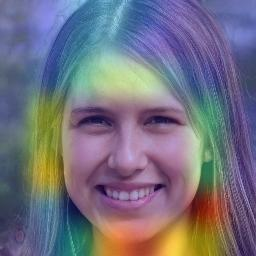

In [ ]:
# Save and display CAMs
overlay_cam_on_image(image_file, cam1)
overlay_cam_on_image(image_file, cam2)
overlay_cam_on_image(image_file, cam3)
overlay_cam_on_image(image_file, cam4)
overlay_cam_on_image(image_file, cam5)

Animation

In [ ]:
from PIL import Image as PILImage

def get_cam_overlay(original_img_path, cam_array, opacity=0.5):
    original_img = keras.utils.load_img(original_img_path)
    original_arr = keras.utils.img_to_array(original_img)

    cam_scaled = np.uint8(255 * cam_array)
    colormap = cm.get_cmap("jet")
    colored_map = colormap(np.arange(256))[:, :3]
    cam_color = colored_map[cam_scaled]

    cam_img = keras.utils.array_to_img(cam_color)
    cam_img = cam_img.resize((original_arr.shape[1], original_arr.shape[0]))
    cam_img = keras.utils.img_to_array(cam_img)

    blended = cam_img * opacity + original_arr
    blended_img = keras.utils.array_to_img(blended)

    return blended_img

In [ ]:
# Generate overlay images
frames = [
    get_cam_overlay(image_file, cam)
    for cam in [cam1, cam2, cam3, cam4, cam5]
]

<ipython-input-18-96aeaaf5da1b>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("jet")


In [ ]:
# Set up figure
fig, ax = plt.subplots()
img_display = ax.imshow(frames[0])
ax.axis('off')

# Animation function
def update(frame_idx):
    img_display.set_data(frames[frame_idx])
    return [img_display]

# Create animation
anim = FuncAnimation(fig, update, frames=len(frames), interval=1000, blit=True)
plt.close()

# Display animation in notebook
from IPython.display import HTML
HTML(anim.to_jshtml())

GIFT

In [ ]:
# Save each frame as PNG to a temporary folder
output_dir = "/content/drive/MyDrive/Deep_Learning_Proyect/GradCAM_Animation_Frames"
os.makedirs(output_dir, exist_ok=True)

frame_paths = []
for i, frame in enumerate(frames):
    path = f"{output_dir}/frame_{i:02d}.png"
    frame.save(path)
    frame_paths.append(path)

In [ ]:
#Create a GIF
gif_path = "/content/drive/MyDrive/Deep_Learning_Proyect/gradcam_animation.gif"
with imageio.get_writer(gif_path, mode='I', duration=1) as writer:
    for path in frame_paths:
        image = imageio.imread(path)
        writer.append_data(image)

print(f"GIF saved to {gif_path}")

<ipython-input-25-1bcb9c21bfe6>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(path)


GIF saved to /content/drive/MyDrive/Deep_Learning_Proyect/gradcam_animation.gif


MP4 saved to /content/drive/MyDrive/gradcam_animation.mp4


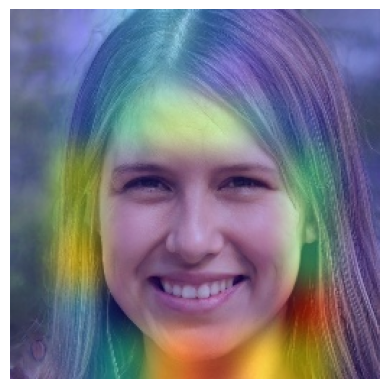

In [ ]:
# Create MP4 using matplotlib (requires ffmpeg installed)
fig, ax = plt.subplots()
img_display = ax.imshow(frames[0])
ax.axis('off')

def update(frame_idx):
    img_display.set_data(frames[frame_idx])
    return [img_display]

anim = FuncAnimation(fig, update, frames=len(frames), interval=1000, blit=True)
mp4_path = "/content/drive/MyDrive/gradcam_animation.mp4"
anim.save(mp4_path, fps=1, extra_args=['-vcodec', 'libx264'])

print(f"MP4 saved to {mp4_path}")

## Feature Extractor

In [ ]:
feat_extractor = KModel(
    inputs= best_model_DSN.input,
    outputs= best_model_DSN.layers[-3].output
)

save_dir = '/content/drive/MyDrive/Deep_Learning_Proyect/Densenet_features_saved'
os.makedirs(save_dir, exist_ok=True)

for split, gen in zip(['train','valid','test'], [train_ds_DSN, valid_ds_DSN, test_ds_DSN]):
    feats = feat_extractor.predict(gen, verbose=1)
    labels = gen.classes
    np.save(os.path.join(save_dir, f'features_{split}.npy'), feats)
    np.save(os.path.join(save_dir, f'labels_{split}.npy'), labels)

print("All features saved.")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(64, 256, 256, 3))
  warnings.warn(msg)


1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 220s 134ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 125ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step
All features saved.


In [ ]:
#for layer in best_model_DSN.layers:
  #layer.trainable = False

#best_model_DSN.summary()  #Trainable parameters will be 0

# **Hybrid SVM**

In [ ]:
# prompt: use features from convolutional network for SVM and applied PCA

import numpy as np
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import os

# Load the extracted features and labels
save_dir = '/content/drive/MyDrive/Deep_Learning_Proyect/Densenet_features_saved'

##X_train = np.load(os.path.join(save_dir, 'features_train.npy'))
#y_train = np.load(os.path.join(save_dir, 'labels_train.npy'))
X_train = np.load(os.path.join(save_dir, 'features_train_FIXED.npy'))
y_train = np.load(os.path.join(save_dir, 'labels_train_FIXED.npy'))

#X_valid = np.load(os.path.join(save_dir, 'features_valid.npy'))
#y_valid = np.load(os.path.join(save_dir, 'labels_valid.npy'))
X_valid = np.load(os.path.join(save_dir, 'features_valid_FIXED.npy'))
y_valid = np.load(os.path.join(save_dir, 'labels_valid_FIXED.npy'))
X_test = np.load(os.path.join(save_dir, 'features_test.npy'))
y_test = np.load(os.path.join(save_dir, 'labels_test.npy'))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(100000, 448)
(100000,)
(20000, 448)
(20000,)
(20000, 448)
(20000,)


In [ ]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_valid, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1], dtype=int32), array([50000, 50000]))
(array([0, 1], dtype=int32), array([10000, 10000]))
(array([0, 1], dtype=int32), array([10000, 10000]))


In [ ]:
# Apply PCA
pca = PCA(n_components=0.95) # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

In [ ]:
#Scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_valid_pca = scaler.transform(X_valid_pca)
X_test_pca = scaler.transform(X_test_pca)

In [ ]:
# Train an SVM classifier (Nosuffle)
svm = SVC(kernel='rbf', C=1, gamma='scale', probability=True) # Example parameters, adjust as needed
svm.fit(X_train_pca, y_train)

# Predictions on validation and test sets
y_pred_valid = svm.predict(X_valid_pca)
y_pred_test = svm.predict(X_test_pca)

# Evaluate the SVM model
print("\n--- NS SVM VALIDATION EVALUATION ---")
print(classification_report(y_valid, y_pred_valid, digits=4))
print(confusion_matrix(y_valid, y_pred_valid))

print("\n--- NS SVM TEST EVALUATION ---")
print(classification_report(y_test, y_pred_test, digits=4))
print(confusion_matrix(y_test, y_pred_test))


--- NS SVM VALIDATION EVALUATION ---
              precision    recall  f1-score   support

           0     0.9930    0.9896    0.9913     10000
           1     0.9896    0.9930    0.9913     10000

    accuracy                         0.9913     20000
   macro avg     0.9913    0.9913    0.9913     20000
weighted avg     0.9913    0.9913    0.9913     20000

[[9896  104]
 [  70 9930]]

--- NS SVM TEST EVALUATION ---
              precision    recall  f1-score   support

           0     0.9909    0.9898    0.9903     10000
           1     0.9898    0.9909    0.9904     10000

    accuracy                         0.9903     20000
   macro avg     0.9904    0.9904    0.9903     20000
weighted avg     0.9904    0.9903    0.9903     20000

[[9898  102]
 [  91 9909]]


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# --- SVM AUC ---
y_proba_test_svm = svm.predict_proba(X_test_pca)[:, 1]  # Probability for class 1 (real)
auc_svm = roc_auc_score(y_test, y_proba_test_svm)
print("AUC for SVM:", round(auc_svm, 4))

# --- VALIDATION EVALUATION ---
print("\n--- VALIDATION SVM EVALUATION ---")
val_acc_svm = accuracy_score(y_valid, y_pred_valid)
print(f"Validation Accuracy (SVM): {val_acc_svm:.4f}")

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# --- SVM AUC ---
y_proba_test_svm = svm.predict_proba(X_test_pca)[:, 1]  # Probability for class 1 (real)
auc_svm = roc_auc_score(y_test, y_proba_test_svm)
print("AUC for SVM:", round(auc_svm, 4))

# --- VALIDATION EVALUATION ---
print("\n--- VALIDATION SVM EVALUATION ---")
val_acc_svm = accuracy_score(y_valid, y_pred_valid)
print(f"Validation Accuracy (SVM): {val_acc_svm:.4f}")

# --- TEST EVALUATION ---
print("\n--- TEST SVM EVALUATION ---")
test_acc_svm = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy (SVM): {test_acc_svm:.4f}")

AUC for SVM: 0.9969

--- VALIDATION SVM EVALUATION ---
Validation Accuracy (SVM): 0.9913
AUC for SVM: 0.9969

--- VALIDATION SVM EVALUATION ---
Validation Accuracy (SVM): 0.9913

--- TEST SVM EVALUATION ---
Test Accuracy (SVM): 0.9903


In [ ]:
# Train an SVM classifier
svm = SVC(kernel='rbf', C=1, gamma='scale', probability=True) # Example parameters, adjust as needed
svm.fit(X_train_pca, y_train)

# Predictions on validation and test sets
y_pred_valid = svm.predict(X_valid_pca)
y_pred_test = svm.predict(X_test_pca)

# Evaluate the SVM model
print("\n--- SVM VALIDATION EVALUATION ---")
print(classification_report(y_valid, y_pred_valid, digits=4))
print(confusion_matrix(y_valid, y_pred_valid))

print("\n--- SVM TEST EVALUATION ---")
print(classification_report(y_test, y_pred_test, digits=4))
print(confusion_matrix(y_test, y_pred_test))



--- SVM VALIDATION EVALUATION ---
              precision    recall  f1-score   support

           0     0.5055    0.3091    0.3836     10000
           1     0.5024    0.6976    0.5841     10000

    accuracy                         0.5033     20000
   macro avg     0.5039    0.5033    0.4839     20000
weighted avg     0.5039    0.5033    0.4839     20000

[[3091 6909]
 [3024 6976]]

--- SVM TEST EVALUATION ---
              precision    recall  f1-score   support

           0     0.8867    0.5401    0.6713     10000
           1     0.6694    0.9310    0.7788     10000

    accuracy                         0.7356     20000
   macro avg     0.7780    0.7356    0.7250     20000
weighted avg     0.7780    0.7356    0.7250     20000

[[5401 4599]
 [ 690 9310]]


In [ ]:
# prompt: I want to save the PCA values for later upload and less computational consumption

import joblib

# Save the PCA model
pca_filepath = '/content/drive/MyDrive/Deep_Learning_Proyect/pca_model.joblib'
joblib.dump(pca, pca_filepath)

# ... (rest of your code)

# Load the PCA model (when you need it later)
pca = joblib.load(pca_filepath)

# Use the loaded PCA model to transform new data
# X_new_pca = pca.transform(X_new)


## **Tunning SVM**

In [ ]:
# Apply PCA
pca2 = PCA(n_components=50)  # Reduce to 50 components
X_train_pca2 = pca2.fit_transform(X_train)
X_valid_pca2 = pca2.transform(X_valid)
X_test_pca2 = pca2.transform(X_test)

In [ ]:
from sklearn.model_selection import train_test_split

# Reduce the dataset size while keeping class balance
X_train_pca_small, _, y_train_small, _ = train_test_split(
    X_train_pca2,
    y_train,
    train_size=10000,
    stratify=y_train,  # <--- IMPORTANT: preserve the ratio of 0s and 1s
    random_state=42    # <--- For reproducibility
)

X_valid_pca_small, _, y_valid_small, _ = train_test_split(
    X_valid_pca2,
    y_valid,
    train_size=10000,
    stratify=y_valid,
    random_state=42
)

X_test_pca_small, _, y_test_small, _ = train_test_split(
    X_test_pca2,
    y_test,
    train_size=10000,
    stratify=y_test,
    random_state=42
)

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [1, 10, 100,1000],  # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001],  # Kernel coefficient
    'kernel': ['rbf'],  # Kernel type
    'class_weight': ['balanced'] # Handling class imbalance
}

# Initialize the SVM classifier
svm2 = SVC(probability=True)  # Enable probability estimates for ROC curve

# Perform GridSearchCV for hyperparameter tuning
#grid_search = GridSearchCV(svm2, param_grid, cv=3, scoring='f1') # Use f1 score for imbalanced dataset
grid_search = RandomizedSearchCV(svm2, param_grid, cv=3,n_iter=10, scoring='f1_macro',verbose=2,n_jobs=-1)
grid_search.fit(X_train_pca_small, y_train_small)

# Get the best estimator
best_svm2 = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the best SVM model on validation and test sets
y_pred_valid_2 = best_svm2.predict(X_valid_pca_small)
y_pred_test_2 = best_svm2.predict(X_test_pca_small)

print("\n--- Validation SVM Evaluation ---")
print(confusion_matrix(y_valid_small, y_pred_valid_2))
print(classification_report(y_valid_small, y_pred_valid_2, digits=4))

print("\n--- Test SVM Evaluation ---")
print(confusion_matrix(y_test_small, y_pred_test_2))
print(classification_report(y_test_small, y_pred_test_2, digits=4))


# Other strategies to reduce bias towards class 1:

# 1. Data Augmentation: If you have limited data for class 0, try augmenting it
#    (rotations, flips, small shifts) to create more samples.

# 2. Cost-Sensitive Learning: Assign higher misclassification costs to class 0
#    in the SVM loss function (you may need to adjust the 'class_weight' parameter
#    or use a different loss function within the SVM).

# 3. Anomaly Detection Techniques: Consider treating class 0 as an anomaly and using
#    anomaly detection algorithms like One-Class SVM or Isolation Forest.

# 4. Ensemble Methods: Combine multiple SVM models trained on different subsets of the
#    data or with different hyperparameters to improve overall performance.

# 5. Resampling Techniques: Use techniques like SMOTE (Synthetic Minority Over-sampling
#    Technique) to create synthetic samples of the minority class.

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'kernel': 'rbf', 'gamma': 0.001, 'class_weight': 'balanced', 'C': 10}

--- Validation SVM Evaluation ---
[[2420 2580]
 [2431 2569]]
              precision    recall  f1-score   support

           0     0.4989    0.4840    0.4913      5000
           1     0.4989    0.5138    0.5063      5000

    accuracy                         0.4989     10000
   macro avg     0.4989    0.4989    0.4988     10000
weighted avg     0.4989    0.4989    0.4988     10000


--- Test SVM Evaluation ---
[[3267 1733]
 [1688 3312]]
              precision    recall  f1-score   support

           0     0.6593    0.6534    0.6564      5000
           1     0.6565    0.6624    0.6594      5000

    accuracy                         0.6579     10000
   macro avg     0.6579    0.6579    0.6579     10000
weighted avg     0.6579    0.6579    0.6579     10000



### Second try tunning

In [ ]:
# Apply PCA
pca3 = PCA(n_components=0.95)
X_train_pca3 = pca3.fit_transform(X_train)
X_valid_pca3 = pca3.transform(X_valid)
X_test_pca3 = pca3.transform(X_test)

#This scales all features to mean 0 and std 1
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_pca3 = scaler.fit_transform(X_train_pca3)
X_valid_pca3 = scaler.transform(X_valid_pca3)
X_test_pca3 = scaler.transform(X_test_pca3)

from sklearn.model_selection import train_test_split

# Reduce the dataset size while keeping class balance
X_train_pca_small, _, y_train_small, _ = train_test_split(
    X_train_pca3,
    y_train,
    train_size=10000,
    stratify=y_train,  # <--- IMPORTANT: preserve the ratio of 0s and 1s
    random_state=42    # <--- For reproducibility
)

X_valid_pca_small, _, y_valid_small, _ = train_test_split(
    X_valid_pca3,
    y_valid,
    train_size=10000,
    stratify=y_valid,
    random_state=42
)

X_test_pca_small, _, y_test_small, _ = train_test_split(
    X_test_pca3,
    y_test,
    train_size=10000,
    stratify=y_test,
    random_state=42
)

import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': np.logspace(-2, 3, 10),  # From 0.01 to 1000 (10 values)
    'gamma': np.logspace(-4, 0, 10),  # From 0.0001 to 1
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

# Initialize the SVM classifier
svm2 = SVC(probability=True)  # Enable probability estimates for ROC curve

# Perform GridSearchCV for hyperparameter tuning
#grid_search = GridSearchCV(svm2, param_grid, cv=3, scoring='f1') # Use f1 score for imbalanced dataset
grid_search = RandomizedSearchCV(svm2, param_grid, cv=3,n_iter=30, scoring='f1_macro',verbose=2,n_jobs=-1)
grid_search.fit(X_train_pca_small, y_train_small)

# Get the best estimator
best_svm2 = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the best SVM model on validation and test sets
y_pred_valid_2 = best_svm2.predict(X_valid_pca_small)
y_pred_test_2 = best_svm2.predict(X_test_pca_small)

print("\n--- Validation SVM Evaluation ---")
print(confusion_matrix(y_valid_small, y_pred_valid_2))
print(classification_report(y_valid_small, y_pred_valid_2, digits=4))

print("\n--- Test SVM Evaluation ---")
print(confusion_matrix(y_test_small, y_pred_test_2))
print(classification_report(y_test_small, y_pred_test_2, digits=4))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best hyperparameters: {'kernel': 'rbf', 'gamma': np.float64(0.016681005372000592), 'class_weight': 'balanced', 'C': np.float64(77.42636826811278)}

--- Validation SVM Evaluation ---
[[3065 1935]
 [3020 1980]]
              precision    recall  f1-score   support

           0     0.5037    0.6130    0.5530      5000
           1     0.5057    0.3960    0.4442      5000

    accuracy                         0.5045     10000
   macro avg     0.5047    0.5045    0.4986     10000
weighted avg     0.5047    0.5045    0.4986     10000


--- Test SVM Evaluation ---
[[4846  154]
 [1232 3768]]
              precision    recall  f1-score   support

           0     0.7973    0.9692    0.8749      5000
           1     0.9607    0.7536    0.8447      5000

    accuracy                         0.8614     10000
   macro avg     0.8790    0.8614    0.8598     10000
weighted avg     0.8790    0.8614    0.8598     10000



In [ ]:
# Apply PCA
pca3 = PCA(n_components=0.95)
X_train_pca3 = pca3.fit_transform(X_train)
X_valid_pca3 = pca3.transform(X_valid)
X_test_pca3 = pca3.transform(X_test)

#This scales all features to mean 0 and std 1
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_pca3 = scaler.fit_transform(X_train_pca3)
X_valid_pca3 = scaler.transform(X_valid_pca3)
X_test_pca3 = scaler.transform(X_test_pca3)

from sklearn.model_selection import train_test_split

# Reduce the dataset size while keeping class balance
X_train_pca_small, _, y_train_small, _ = train_test_split(
    X_train_pca3,
    y_train,
    train_size=25000,
    stratify=y_train,  # <--- IMPORTANT: preserve the ratio of 0s and 1s
    random_state=42    # <--- For reproducibility
)

X_valid_pca_small, _, y_valid_small, _ = train_test_split(
    X_valid_pca3,
    y_valid,
    train_size=5000,
    stratify=y_valid,
    random_state=42
)

X_test_pca_small, _, y_test_small, _ = train_test_split(
    X_test_pca3,
    y_test,
    train_size=5000,
    stratify=y_test,
    random_state=42
)

import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# Define the parameter grid for hyperparameter tuning
param_grid = {
       'C': np.linspace(50, 150, 10),
    'gamma': np.linspace(0.005, 0.05, 10),
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

# Initialize the SVM classifier
svm2 = SVC(probability=True)  # Enable probability estimates for ROC curve

# Perform GridSearchCV for hyperparameter tuning
#grid_search = GridSearchCV(svm2, param_grid, cv=3, scoring='f1') # Use f1 score for imbalanced dataset
grid_search = RandomizedSearchCV(svm2, param_grid, cv=3,n_iter=30, scoring='f1_macro',verbose=2,n_jobs=-1)
grid_search.fit(X_train_pca_small, y_train_small)

# Get the best estimator
best_svm2 = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the best SVM model on validation and test sets
y_pred_valid_2 = best_svm2.predict(X_valid_pca_small)
y_pred_test_2 = best_svm2.predict(X_test_pca_small)

print("\n--- Validation SVM Evaluation ---")
print(confusion_matrix(y_valid_small, y_pred_valid_2))
print(classification_report(y_valid_small, y_pred_valid_2, digits=4))

print("\n--- Test SVM Evaluation ---")
print(confusion_matrix(y_test_small, y_pred_test_2))
print(classification_report(y_test_small, y_pred_test_2, digits=4))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best hyperparameters: {'kernel': 'rbf', 'gamma': np.float64(0.015000000000000003), 'class_weight': 'balanced', 'C': np.float64(72.22222222222223)}

--- Validation SVM Evaluation ---
[[1241 1259]
 [1270 1230]]
              precision    recall  f1-score   support

           0     0.4942    0.4964    0.4953      2500
           1     0.4942    0.4920    0.4931      2500

    accuracy                         0.4942      5000
   macro avg     0.4942    0.4942    0.4942      5000
weighted avg     0.4942    0.4942    0.4942      5000


--- Test SVM Evaluation ---
[[1801  699]
 [ 637 1863]]
              precision    recall  f1-score   support

           0     0.7387    0.7204    0.7294      2500
           1     0.7272    0.7452    0.7361      2500

    accuracy                         0.7328      5000
   macro avg     0.7329    0.7328    0.7328      5000
weighted avg     0.7329    0.7328    0.7328      5000



## **Final Model** **SVM**

In [ ]:
pca = PCA(n_components=0.95) # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

#This scales all features to mean 0 and std 1
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_valid_pca = scaler.transform(X_valid_pca)
X_test_pca = scaler.transform(X_test_pca)

In [ ]:
# Train an SVM classifier
svm = SVC(kernel='rbf', C=77.42636826811278, gamma=0.016681005372000592,class_weight='balanced', probability=True)
svm.fit(X_train_pca, y_train)
# Predictions on validation and test sets
y_pred_valid = svm.predict(X_valid_pca)
y_pred_test = svm.predict(X_test_pca)

# Evaluate the SVM model
print("\n--- SVM BEST MODEL VALIDATION EVALUATION ---")
print(classification_report(y_valid, y_pred_valid, digits=4))
print(confusion_matrix(y_valid, y_pred_valid))

print("\n--- SVM BEST MODEL TEST EVALUATION ---")
print(classification_report(y_test, y_pred_test, digits=4))
print(confusion_matrix(y_test, y_pred_test))


--- SVM BEST MODEL VALIDATION EVALUATION ---
              precision    recall  f1-score   support

           0     0.8195    0.9989    0.9004     10000
           1     0.9986    0.7800    0.8759     10000

    accuracy                         0.8894     20000
   macro avg     0.9091    0.8895    0.8881     20000
weighted avg     0.9091    0.8894    0.8881     20000

[[9989   11]
 [2200 7800]]

--- SVM BEST MODEL TEST EVALUATION ---
              precision    recall  f1-score   support

           0     0.8194    0.9992    0.9004     10000
           1     0.9990    0.7797    0.8758     10000

    accuracy                         0.8894     20000
   macro avg     0.9092    0.8894    0.8881     20000
weighted avg     0.9092    0.8894    0.8881     20000

[[9992    8]
 [2203 7797]]


# **Naive Bayes** **Classifier**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# Initialize Gaussian Naive Bayes
gnb = GaussianNB()

# Fit the model on training data
gnb.fit(X_train_pca, y_train)

# Predict on validation and test sets
y_pred_valid_nb = gnb.predict(X_valid_pca)
y_pred_test_nb = gnb.predict(X_test_pca)

# Validation set evaluation
print("\n--- NAIVE BAYES VALIDATION EVALUATION ---")
print(confusion_matrix(y_valid, y_pred_valid_nb))
print(classification_report(y_valid, y_pred_valid_nb, digits=4))

# Test set evaluation
print("\n--- NAIVE BAYES TEST EVALUATION ---")
print(confusion_matrix(y_test, y_pred_test_nb))
print(classification_report(y_test, y_pred_test_nb, digits=4))


--- NAIVE BAYES VALIDATION EVALUATION ---
[[1942 8058]
 [2824 7176]]
              precision    recall  f1-score   support

           0     0.4075    0.1942    0.2630     10000
           1     0.4711    0.7176    0.5688     10000

    accuracy                         0.4559     20000
   macro avg     0.4393    0.4559    0.4159     20000
weighted avg     0.4393    0.4559    0.4159     20000


--- NAIVE BAYES TEST EVALUATION ---
[[1903 8097]
 [2884 7116]]
              precision    recall  f1-score   support

           0     0.3975    0.1903    0.2574     10000
           1     0.4678    0.7116    0.5645     10000

    accuracy                         0.4510     20000
   macro avg     0.4326    0.4510    0.4109     20000
weighted avg     0.4326    0.4510    0.4109     20000



In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import Binarizer
from sklearn.metrics import classification_report, confusion_matrix

# Binarize the PCA data (threshold = 0 by default)
binarizer = Binarizer(threshold=0.0)

X_train_bin = binarizer.fit_transform(X_train_pca)
X_valid_bin = binarizer.transform(X_valid_pca)
X_test_bin = binarizer.transform(X_test_pca)

# Initialize and fit BernoulliNB
bnb = BernoulliNB()
bnb.fit(X_train_bin, y_train)

# Predict on validation and test sets
y_pred_valid_bnb = bnb.predict(X_valid_bin)
y_pred_test_bnb = bnb.predict(X_test_bin)

# Validation set evaluation
print("\n--- BERNOULLI NAIVE BAYES VALIDATION EVALUATION ---")
print(confusion_matrix(y_valid, y_pred_valid_bnb))
print(classification_report(y_valid, y_pred_valid_bnb, digits=4))

# Test set evaluation
print("\n--- BERNOULLI NAIVE BAYES TEST EVALUATION ---")
print(confusion_matrix(y_test, y_pred_test_bnb))
print(classification_report(y_test, y_pred_test_bnb, digits=4))

#Corrio en un segundo


--- BERNOULLI NAIVE BAYES VALIDATION EVALUATION ---
[[9374  626]
 [   1 9999]]
              precision    recall  f1-score   support

           0     0.9999    0.9374    0.9676     10000
           1     0.9411    0.9999    0.9696     10000

    accuracy                         0.9687     20000
   macro avg     0.9705    0.9687    0.9686     20000
weighted avg     0.9705    0.9687    0.9686     20000


--- BERNOULLI NAIVE BAYES TEST EVALUATION ---
[[9412  588]
 [   3 9997]]
              precision    recall  f1-score   support

           0     0.9997    0.9412    0.9696     10000
           1     0.9444    0.9997    0.9713     10000

    accuracy                         0.9705     20000
   macro avg     0.9721    0.9705    0.9704     20000
weighted avg     0.9721    0.9705    0.9704     20000



In [ ]:
from sklearn.metrics import roc_auc_score

# --- SVM AUC ---
y_proba_test_svm = svm.predict_proba(X_test_pca)[:, 1]  # Probability for class 1 (real)
auc_svm = roc_auc_score(y_test, y_proba_test_svm)
print("AUC for SVM:", round(auc_svm, 4))

# --- Naive Bayes AUC ---
y_proba_test_bnb = bnb.predict_proba(X_test_pca)[:, 1]  # Probability for class 1 (real)
auc_bnb = roc_auc_score(y_test, y_proba_test_bnb)
print("AUC for Naive Bayes:", round(auc_bnb, 4))

AUC for SVM: 0.5
AUC for Naive Bayes: 0.9815


In [ ]:
# validation
print("\n--- VALIDATION DSN EVALUATION ---")
val_loss, val_acc = best_model_DSN.evaluate(valid_ds_DSN, verbose=1)
print(f"Val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")

# test
print("\n--- TEST DSN EVALUATION ---")
test_loss, test_acc = best_model_DSN.evaluate(test_ds_DSN, verbose=1)
print(f"Test loss: {test_loss:.4f}, test acc: {test_acc:.4f}")

from sklearn.metrics import accuracy_score

# --- VALIDATION EVALUATION ---
print("\n--- VALIDATION SVM EVALUATION ---")
val_acc_svm = accuracy_score(y_valid, y_pred_valid)
print(f"Validation Accuracy (SVM): {val_acc_svm:.4f}")

print("\n--- VALIDATION NAIVE BAYES EVALUATION ---")
val_acc_bnb = accuracy_score(y_valid, y_pred_valid_bnb)
print(f"Validation Accuracy (Naive Bayes): {val_acc_bnb:.4f}")

# --- TEST EVALUATION ---
print("\n--- TEST SVM EVALUATION ---")
test_acc_svm = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy (SVM): {test_acc_svm:.4f}")

print("\n--- TEST NAIVE BAYES EVALUATION ---")
test_acc_bnb = accuracy_score(y_test, y_pred_test_bnb)
print(f"Test Accuracy (Naive Bayes): {test_acc_bnb:.4f}")


--- VALIDATION SVM EVALUATION ---
Validation Accuracy (SVM): 0.8894

--- VALIDATION NAIVE BAYES EVALUATION ---
Validation Accuracy (Naive Bayes): 0.9687

--- TEST SVM EVALUATION ---
Test Accuracy (SVM): 0.8894

--- TEST NAIVE BAYES EVALUATION ---
Test Accuracy (Naive Bayes): 0.9705


In [ ]:
from sklearn.metrics import log_loss

# Get predicted probabilities
y_proba_valid_svm = svm.predict_proba(X_valid_pca)
y_proba_test_svm = svm.predict_proba(X_test_pca)

y_proba_valid_bnb = bnb.predict_proba(X_valid_pca)
y_proba_test_bnb = bnb.predict_proba(X_test_pca)

# Compute log loss
val_logloss_svm = log_loss(y_valid, y_proba_valid_svm)
test_logloss_svm = log_loss(y_test, y_proba_test_svm)

val_logloss_bnb = log_loss(y_valid, y_proba_valid_bnb)
test_logloss_bnb = log_loss(y_test, y_proba_test_bnb)

# Print results
print("\n--- VALIDATION LOG-LOSS ---")
print(f"SVM: {val_logloss_svm:.4f}")
print(f"Naive Bayes: {val_logloss_bnb:.4f}")

print("\n--- TEST LOG-LOSS ---")
print(f"SVM: {test_logloss_svm:.4f}")


--- VALIDATION LOG-LOSS ---
SVM: 0.6931
Naive Bayes: 0.6913

--- TEST LOG-LOSS ---
SVM: 0.6931


## Final Graphics

## Plots

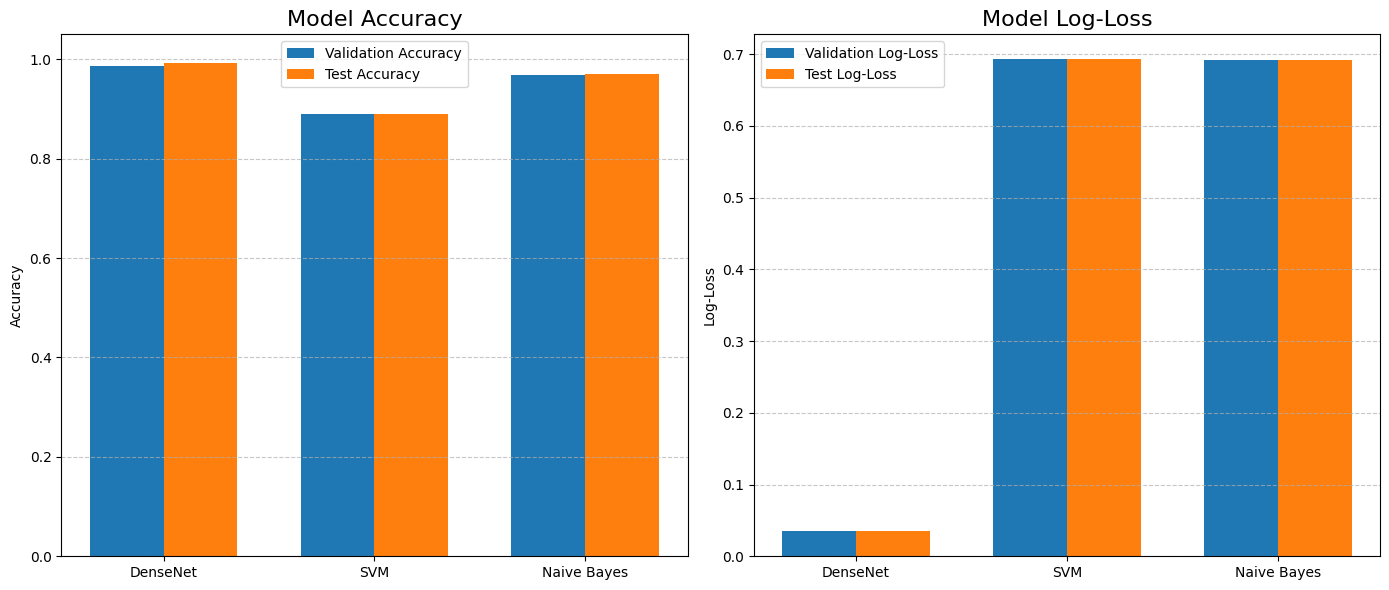

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

val_acc_dsn = 0.9863
test_acc_dsn = 0.9933
val_loss_dsn = 0.0352
test_loss_dsn = 0.0356

# Example values (replace these with your actual results)
models = ['DenseNet', 'SVM', 'Naive Bayes']


# Accuracy
val_accs = [val_acc_dsn, val_acc_svm, val_acc_bnb]
test_accs = [test_acc_dsn, test_acc_svm, test_acc_bnb]

# Log Loss
val_losses = [val_loss_dsn, val_logloss_svm, val_logloss_bnb]
test_losses = [test_loss_dsn, test_logloss_svm, test_logloss_bnb]

x = np.arange(len(models))
width = 0.35  # Bar width

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy plot
axes[0].bar(x - width/2, val_accs, width, label='Validation Accuracy')
axes[0].bar(x + width/2, test_accs, width, label='Test Accuracy')
axes[0].set_title('Model Accuracy', fontsize=16)
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1.05)
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Log Loss plot
axes[1].bar(x - width/2, val_losses, width, label='Validation Log-Loss')
axes[1].bar(x + width/2, test_losses, width, label='Test Log-Loss')
axes[1].set_title('Model Log-Loss', fontsize=16)
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].set_ylabel('Log-Loss')
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example dictionary with values you get from classification reports
metrics_data = {
    'Model': ['DenseNet', 'DenseNet+SVM', 'DenseNet+NB',
              'Xception', 'Xception+SVM', 'Xception+NB'],
    'Precision': [0.9777, 0.8198, 0.8200, 0.9781, 0.8100, 0.8001],
    'Recall':    [0.9974, 0.9992, 0.9981, 0.9970, 0.9902, 0.9880],
    'F1-score':  [0.9874, 0.9006, 0.9003, 0.9875, 0.8921, 0.8860],
    'Accuracy':  [0.9873, 0.8898, 0.8841, 0.9872, 0.8870, 0.8805]
}

df = pd.DataFrame(metrics_data)
df = df.set_index('Model')

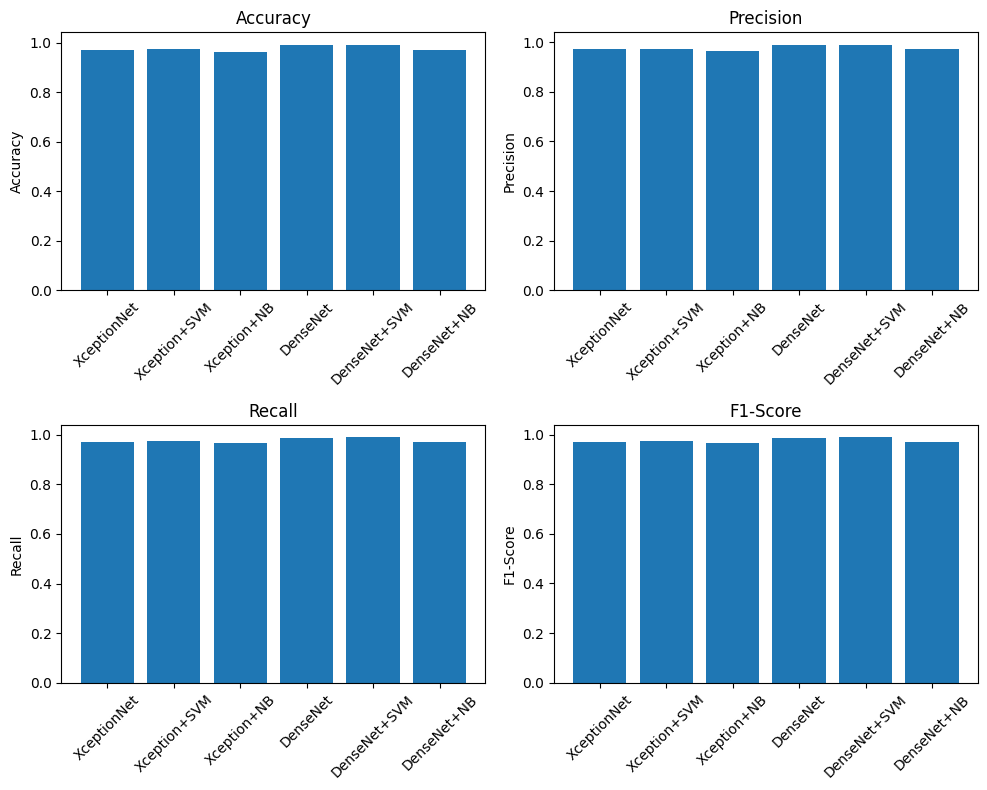

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid of subplots

# Assuming metrics is a list of the 4 metrics (Precision, Recall, F1, Accuracy)
metrics = ['Accuracy','Precision', 'Recall', 'F1-Score']
values = {
    'XceptionNet': [0.9722, 0.9723, 0.9721, 0.9721],
    'Xception+SVM': [0.9743, 0.9743, 0.9743, 0.9743],
    'Xception+NB': [0.9646, 0.9647, 0.9647, 0.9646],
        'DenseNet': [0.9933, 0.9875, 0.9873, 0.9873],
    'DenseNet+SVM': [0.9903, 0.9904, 0.9904,0.9903],
    'DenseNet+NB': [0.9705, 0.9721, 0.9705, 0.9704]}

# Flatten the axes array to access each subplot
axes = axes.flatten()

# Loop through each metric and subplot axis
for i, metric in enumerate(metrics):
    ax = axes[i]  # Access the ith subplot
    ax.bar(values.keys(), [model[i] for model in values.values()])
    ax.set_title(metric)
    #ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Deep_Learning_Proyect/metrics_camparasion.png', format='png')
plt.show()

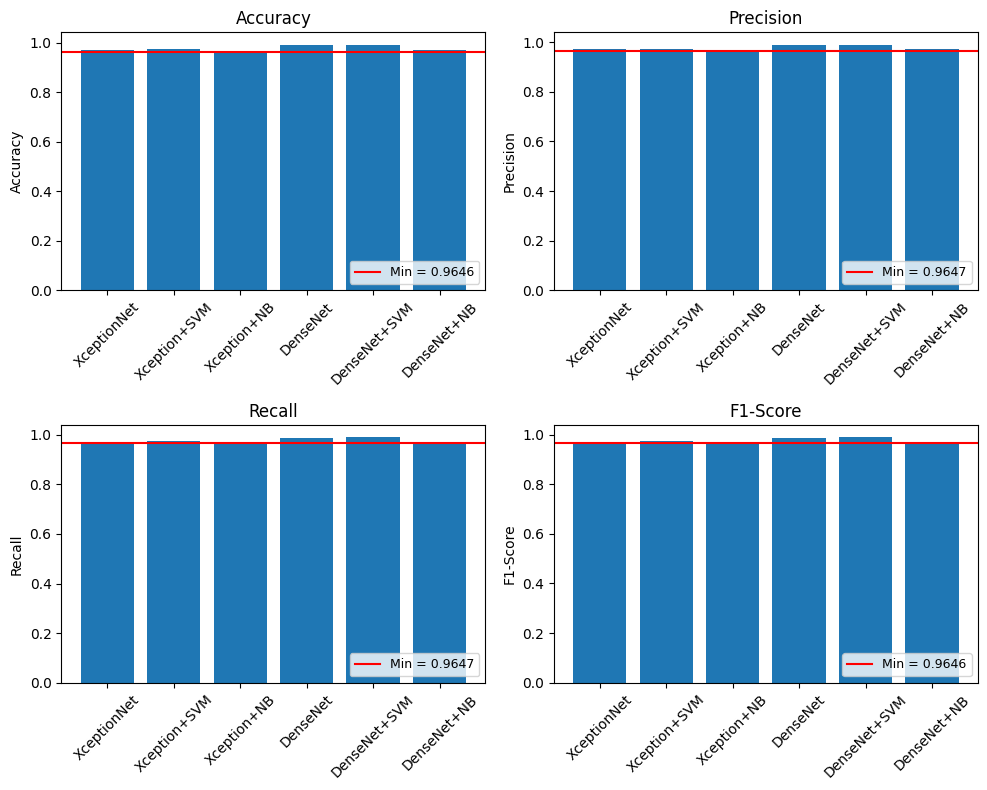

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid of subplots

# Metrics and values for each model
metrics = ['Accuracy','Precision', 'Recall', 'F1-Score']
values = {
    'XceptionNet': [0.9722, 0.9723, 0.9721, 0.9721],
    'Xception+SVM': [0.9743, 0.9743, 0.9743, 0.9743],
    'Xception+NB': [0.9646, 0.9647, 0.9647, 0.9646],
    'DenseNet': [0.9933, 0.9875, 0.9873, 0.9873],
    'DenseNet+SVM': [0.9903, 0.9904, 0.9904, 0.9903],
    'DenseNet+NB': [0.9705, 0.9721, 0.9705, 0.9704]
}

# Flatten the axes array for easy access
axes = axes.flatten()

# Loop through each metric and subplot axis
for i, metric in enumerate(metrics):
    ax = axes[i]
    metric_values = [model[i] for model in values.values()]
    ax.bar(values.keys(), metric_values)

    # Plot red horizontal line at the minimum value
    min_val = min(metric_values)
    ax.axhline(min_val, color='red', linestyle='-', linewidth=1.5, label=f"Min = {min_val:.4f}")

    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc='lower right', fontsize=9)

# Adjust the layout
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Deep_Learning_Proyect/metrics_comparison_line.png', format='png')
plt.show()

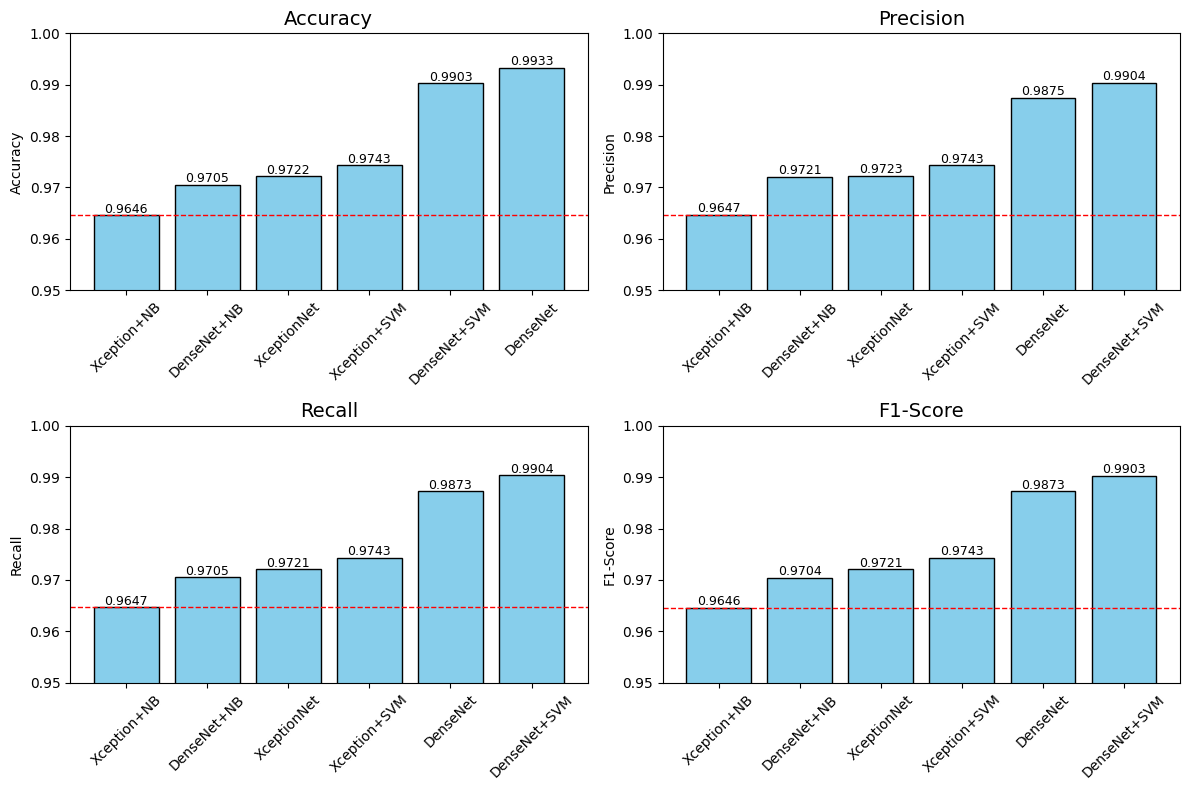

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid

# Metric names and values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = {
    'XceptionNet': [0.9722, 0.9723, 0.9721, 0.9721],
    'Xception+SVM': [0.9743, 0.9743, 0.9743, 0.9743],
    'Xception+NB': [0.9646, 0.9647, 0.9647, 0.9646],
    'DenseNet': [0.9933, 0.9875, 0.9873, 0.9873],
    'DenseNet+SVM': [0.9903, 0.9904, 0.9904, 0.9903],
    'DenseNet+NB': [0.9705, 0.9721, 0.9705, 0.9704]
}

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through each metric and subplot axis
for i, metric in enumerate(metrics):
    ax = axes[i]

    # Extract current metric values
    metric_values = [model[i] for model in values.values()]
    models = list(values.keys())

    # Sort models by metric value
    sorted_data = sorted(zip(models, metric_values), key=lambda x: x[1])
    sorted_models, sorted_vals = zip(*sorted_data)

    # Plot
    bars = ax.bar(sorted_models, sorted_vals, color='skyblue', edgecolor='black')

    # Annotate bars with values
    for j, val in enumerate(sorted_vals):
        ax.text(j, val + 0.0005, f"{val:.4f}", ha='center', fontsize=9)

    # Add red horizontal line at minimum
    ax.axhline(min(sorted_vals), color='red', linestyle='--', linewidth=1)

    ax.set_title(metric, fontsize=14)
    ax.set_ylabel(metric)
    ax.set_ylim(0.95, 1.0)
    ax.tick_params(axis='x', rotation=45)

# Adjust layout and save
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Deep_Learning_Proyect/metrics_comparison_better.png', format='png')
plt.show()

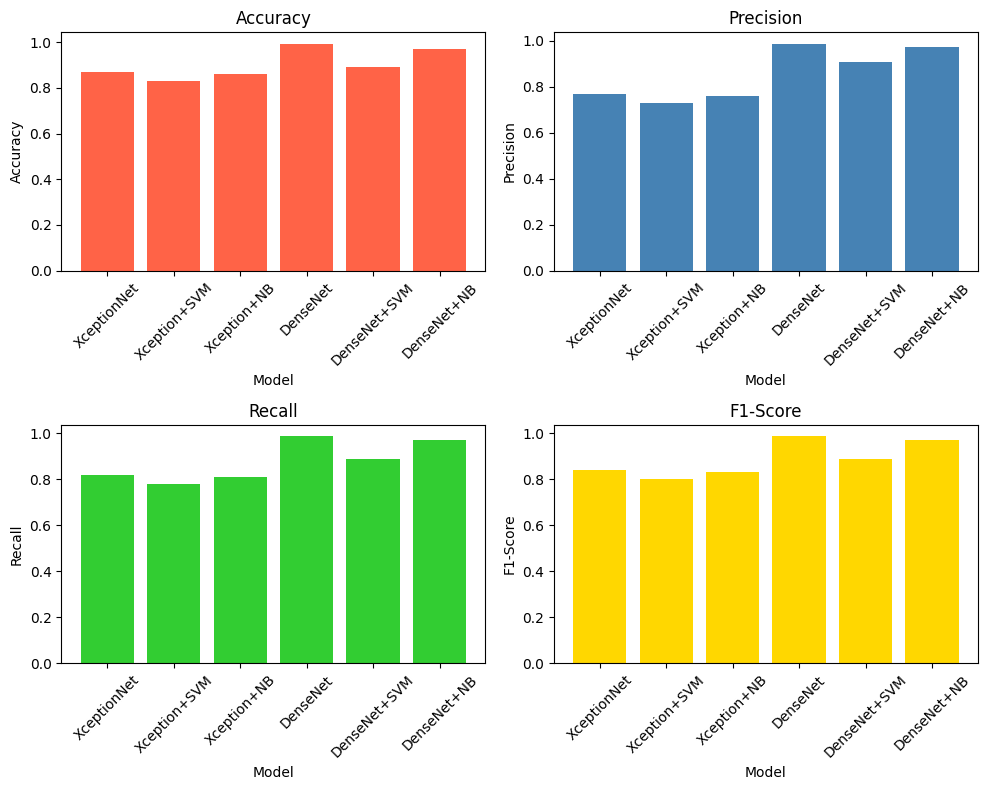

In [ ]:
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid of subplots

# Assuming metrics is a list of the 4 metrics (Precision, Recall, F1, Accuracy)
metrics = ['Accuracy','Precision', 'Recall', 'F1-Score']
values = {
    'XceptionNet': [0.87, 0.77, 0.82, 0.84],
    'Xception+SVM': [0.83, 0.73, 0.78, 0.80],
    'Xception+NB': [0.86, 0.76, 0.81, 0.83],
        'DenseNet': [0.9933, 0.9875, 0.9873, 0.9873],
    'DenseNet+SVM': [0.8894, 0.9092, 0.8894,0.8881],
    'DenseNet+NB': [0.9705, 0.9721, 0.9705, 0.9704]}

colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700']

# Flatten the axes array to access each subplot
axes = axes.flatten()

# Loop through each metric and subplot axis
for i, metric in enumerate(metrics):
    ax = axes[i]  # Access the ith subplot
    ax.bar(values.keys(), [model[i] for model in values.values()], color=colors[i])  # Use a different color for each metric
    ax.set_title(metric)
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)

    # Rotate the x-axis labels by 45 degrees
    ax.tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout()
plt.show()

##Confusion Matrices

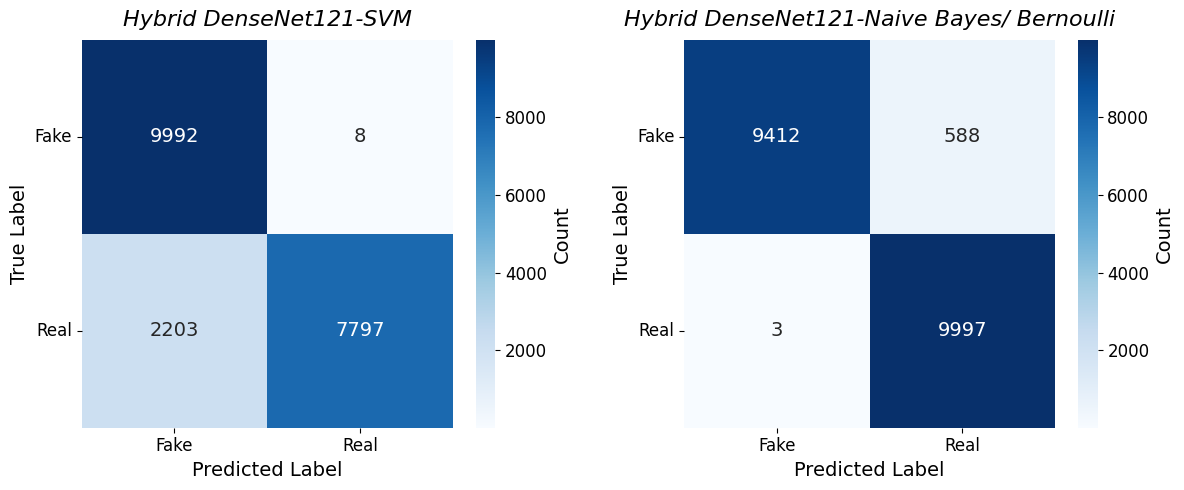

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, cbar_kws={'label': 'Count', 'shrink': 1},
        annot_kws={"size": 14}, ax=ax)
    ax.set_title(title, fontdict={'style': 'italic'},fontsize=16, pad=10)
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_ylabel('True Label', fontsize=14)
    ax.set_xticklabels(['Fake', 'Real'], fontsize=12)  # 0 is fake and 1 is real
    ax.set_yticklabels(['Fake', 'Real'], fontsize=12, rotation=0)

    # Customize the color bar
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Count', size=14)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot SVM confusion matrix
plot_confusion(y_test, y_pred_test, "Hybrid DenseNet121-SVM", ax=axes[0])

# Plot Naive Bayes confusion matrix
plot_confusion(y_test, y_pred_test_bnb, "Hybrid DenseNet121-Naive Bayes/ Bernoulli", ax=axes[1])

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)  # Increase horizontal spacing
plt.savefig('/content/drive/MyDrive/Deep_Learning_Proyect/hybrid_confusion_matrices.png', format='png')
plt.show()

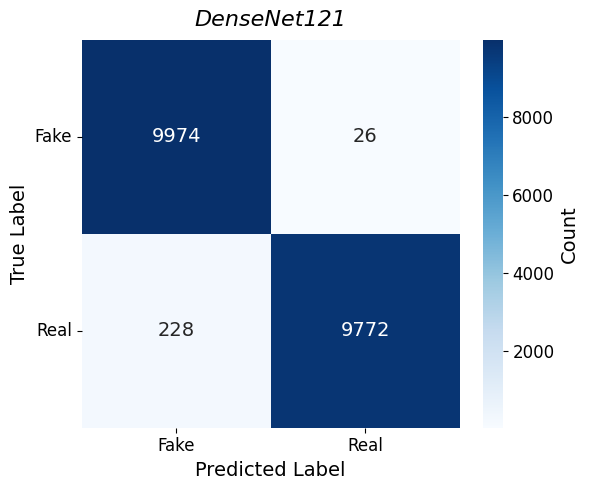

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Hardcoded DenseNet confusion matrix
cm_densenet = np.array([[9974, 26],
                        [228, 9772]])

def plot_confusion_from_cm(cm, title, ax):
    heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                          cbar_kws={'label': 'Count', 'shrink': 1},
                          annot_kws={"size": 14}, ax=ax)
    ax.set_title(title, fontdict={'style': 'italic'}, fontsize=16, pad=10)
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_ylabel('True Label', fontsize=14)
    ax.set_xticklabels(['Fake', 'Real'], fontsize=12)
    ax.set_yticklabels(['Fake', 'Real'], fontsize=12, rotation=0)

    # Customize the color bar
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Count', size=14)

# Create figure for one confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
plot_confusion_from_cm(cm_densenet, "DenseNet121", ax)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Deep_Learning_Proyect/densenet_confusion_matrix.png', format='png')
plt.show()

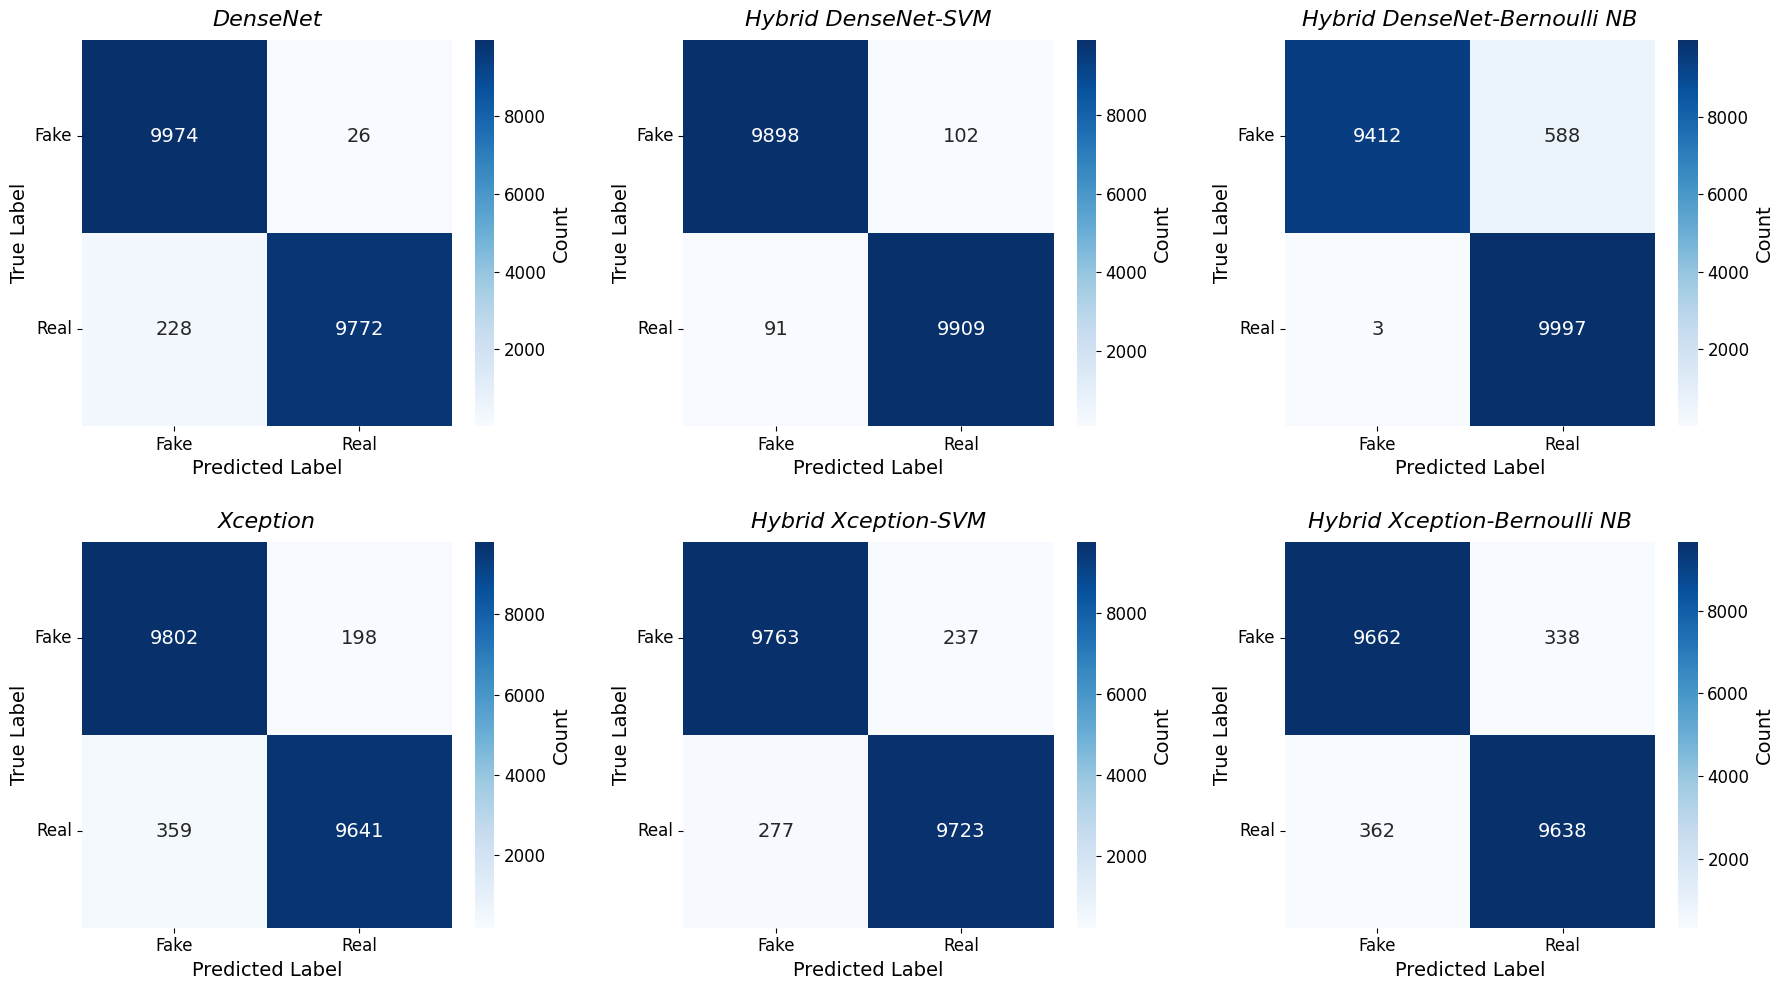

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion(cm, title, ax):
    heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                          cbar_kws={'label': 'Count', 'shrink': 1},
                          annot_kws={"size": 14}, ax=ax)
    ax.set_title(title, fontdict={'style': 'italic'}, fontsize=16, pad=10)
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_ylabel('True Label', fontsize=14)
    ax.set_xticklabels(['Fake', 'Real'], fontsize=12)
    ax.set_yticklabels(['Fake', 'Real'], fontsize=12, rotation=0)

    # Customize the color bar
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Count', size=14)

# Confusion matrices (TN, FP, FN, TP)
cms = [
    (np.array([[9974, 26], [228, 9772]]), "DenseNet"),
    (np.array([[9898, 102], [91, 9909]]), "Hybrid DenseNet-SVM"),
    (np.array([[9412, 588], [3, 9997]]), "Hybrid DenseNet-Bernoulli NB"),
    (np.array([[9802, 198], [359, 9641]]), "Xception"),
    (np.array([[9763, 237], [277, 9723]]), "Hybrid Xception-SVM"),
    (np.array([[9662, 338], [362, 9638]]), "Hybrid Xception-Bernoulli NB"),
]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot all confusion matrices
for i, (cm, title) in enumerate(cms):
    row = i // 3
    col = i % 3
    plot_confusion(cm, title, ax=axes[row, col])

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.savefig('/content/drive/MyDrive/Deep_Learning_Proyect/all_confusion_matrices.png', format='png')
plt.show()